In [1]:
pip install torch pytorch-lightning pytorch_forecasting

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.5/127.5 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.2/308.2 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.2/147.2 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 11.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=cd787c3d24211eb75b2d89dbecdac2cac8700633b4e918c58302263594bad5cd
  Stored in directory: /root/.cache/pip/wheels/36/86/43/c32981b55b0d0a78b9762fd4fa7d6de0da0a46fd035cedfccb
Successfully built pyperclip
  Attempting uninstall: optuna
    Found existing installation: optuna 3.1.0
    Uninstalling optuna-3.1.0:
      Successfully uninstalled optuna-3.1.0
Note: you may need to restart t

In [2]:
import warnings
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
import random
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf 
import tensorboard as tb 
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile


# Define the path to 'total.csv'
#total_csv_path = '/kaggle/input/total-final/total.csv'
total_csv_path = '/kaggle/input/total-with-category/total_with_category.csv'

# Load 'total.csv' and set index to 'date'
#data = pd.read_csv(total_csv_path, parse_dates=['date'], index_col='date')
data = pd.read_csv(total_csv_path)


data = data[data['store'] == 548]

# Add 'unique_id' column
data['unique_id'] = data['item_nbr'].astype(str) + '_' + data['store'].astype(str)

# Drop 'item_nbr' and 'store' columns
data.drop(['item_nbr', 'store'], axis=1, inplace=True)

# Select 1 random unique_ids and filter the data
random_unique_ids = random.sample(list(data['unique_id'].unique()), 1)
data = data[data['unique_id'].isin(random_unique_ids)]

#data = data.drop('index', axis=1)
# Sort the data by 'unique_id' and 'date'
data.sort_values(by=['unique_id', 'date'], inplace=True)

# Convert the date column to a datetime object and set it as the index
data['date'] = pd.to_datetime(data['date'])
#data = data.set_index('date')

data

,unit_sales,bogo,circular_discount,circular,circedlp,coupon,discount_value,discount,fp_discount,front_page,fpedlp,gas,nopromo,date,category,unique_id
8705079,6.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,1.0,2021-01-23,GROCERY,905299_548
8705080,6.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,1.0,2021-01-24,GROCERY,905299_548
8705081,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,1.0,2021-01-25,GROCERY,905299_548
8705082,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,1.0,2021-01-26,GROCERY,905299_548
8705083,2.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,1.0,2021-01-27,GROCERY,905299_548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8705835,4.0,0.0,0.0,0.0,0.0,0.0,0.1111,1.0,0.0,0.0,0.0,0.0,0.0,2023-02-18,GROCERY,905299_548
8705836,9.0,0.0,0.0,0.0,0.0,0.0,0.1111,1.0,0.0,0.0,0.0,0.0,0.0,2023-02-19,GROCERY,905299_548
8705837,17.0,0.0,0.0,0.0,0.0,0.0,0.1111,1.0,0.0,0.0,0.0,0.0,0.0,2023-02-20,GROCERY,905299_548
8705838,13.0,0.0,0.0,0.0,0.0,0.0,0.1111,1.0,0.0,0.0,0.0,0.0,0.0,2023-02-21,GROCERY,905299_548


In [3]:
# Add an integer-based time index to the dataset
data["time_idx"] = (data["date"] - data["date"].min()).dt.days

lookback = 14
prediction_length = 1

unique_ids = data['unique_id'].unique()

training_data_list = []
validation_data_list = []
testing_data_list = []

for unique_id in unique_ids:
    unique_id_data = data[data["unique_id"] == unique_id]
    
    train_split = int(0.7 * unique_id_data["time_idx"].max())
    val_split = int(0.8 * unique_id_data["time_idx"].max())

    training_data_list.append(unique_id_data[unique_id_data["time_idx"] <= train_split])
    validation_data_list.append(unique_id_data[(unique_id_data["time_idx"] > train_split) & (unique_id_data["time_idx"] <= val_split)])
    testing_data_list.append(unique_id_data[unique_id_data["time_idx"] > val_split])

training_data = pd.concat(training_data_list)
validation_data = pd.concat(validation_data_list)
testing_data = pd.concat(testing_data_list)


training = TimeSeriesDataSet(training_data, time_idx="time_idx", target="unit_sales", group_ids=["unique_id"],
                             min_encoder_length=lookback //2, max_encoder_length=lookback, min_prediction_length=1,
                             max_prediction_length=prediction_length, static_categoricals=["unique_id", "category"],
                             time_varying_known_reals=["bogo", "circular_discount", "circular", "circedlp", "coupon",
                                                       "discount_value", "discount", "fp_discount", "front_page", "fpedlp",
                                                       "gas", "nopromo"],
                             target_normalizer=GroupNormalizer(groups=["unique_id"], transformation="softplus"),
                             add_relative_time_idx=True, add_target_scales=True, add_encoder_length=True)


validation = TimeSeriesDataSet.from_dataset(training, validation_data, predict=True, stop_randomization=True)
testing = TimeSeriesDataSet.from_dataset(training, testing_data, predict=True, stop_randomization=True)

# Model

In [4]:
from pytorch_forecasting.metrics import MASE, MAE

# Create data loaders
batch_size = 28
train_dataloader = training.to_dataloader(train=True,
                                          batch_size=batch_size, num_workers=2)
val_dataloader = validation.to_dataloader(train=False,
                                          batch_size=batch_size, num_workers=2)

# Create our TFT model with MeanSquaredError loss function
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.01,
    hidden_size=64,
    attention_head_size=6,
    dropout=0.2,
    hidden_continuous_size=64,
    output_size=1,
    loss=MAE(),
    reduce_on_plateau_patience=4)


# Define Pytorch Lightning Trainer & Callbacks
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4,
                                    patience=5, verbose=True, mode="min")
lr_logger = LearningRateMonitor()
logger = TensorBoardLogger("logs/lightning_logs")  # Adjusted the path for a local directory

epochs = 50
trainer = pl.Trainer(max_epochs=epochs, gpus=1,  # Changed 'accelerator' and 'devices' to 'gpus'
                     enable_model_summary=True, gradient_clip_val=0.1,
                     callbacks=[lr_logger, early_stop_callback], logger=logger)


trainer.fit(tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/parsing.py:270: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  f"Attribute {k!r} is an instance of `nn.Module` and is already saved during checkpointing."
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/parsing.py:270: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  f"Attribute {k!r} is an instance of `nn.Module` and is already saved during checkpointing."
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:479: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu

Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:1613: PossibleUserWarning: The number of training batches (19) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [5]:
best_model_path = trainer.checkpoint_callback.best_model_path
print(best_model_path)
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

logs/lightning_logs/lightning_logs/version_0/checkpoints/epoch=8-step=171.ckpt


# Prediction on the Test Set

In [6]:
def predict_sliding_window(model, training_dataset, data, unique_ids, window_size, batch_size=32, num_workers=2):
    predictions_dict = {}
    
    for unique_id in unique_ids:
        unique_id_data = data[data["unique_id"] == unique_id]
        data_length = len(unique_id_data)
        predictions = []

        for start_idx in range(0, data_length - window_size + 1):
            windowed_data = unique_id_data.iloc[start_idx : start_idx + window_size]
            windowed_dataset = TimeSeriesDataSet.from_dataset(training_dataset, windowed_data, predict=True, stop_randomization=True)
            dataloader = windowed_dataset.to_dataloader(train=False, batch_size=batch_size, num_workers=num_workers)
            raw_predictions, _ = model.predict(dataloader, mode="raw", return_x=True)
            # Add the last prediction from the window and round it to the nearest integer
            predictions.append(np.round(raw_predictions["prediction"][0, -1, 0]))
            #predictions.append(raw_predictions["prediction"][0, -1, 0])

        predictions_dict[unique_id] = np.array(predictions)
    
    return predictions_dict

window_size = 14
test_predictions_dict = predict_sliding_window(best_tft, training, testing_data, random_unique_ids, window_size)

# Plot

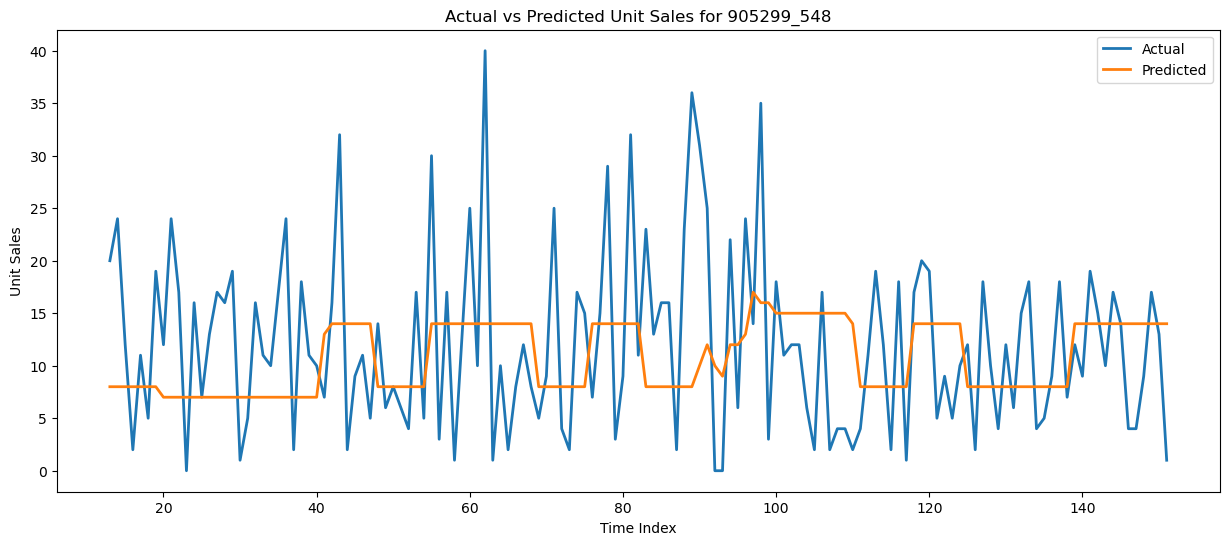

In [7]:
for unique_id in random_unique_ids:
    fig, ax = plt.subplots(figsize=(15, 6))
    
    test_data = testing_data[testing_data["unique_id"] == unique_id]
    test_predictions = test_predictions_dict[unique_id]
    
    actuals = test_data["unit_sales"].values
    actuals_range = np.arange(window_size - 1, len(actuals))
    
    ax.plot(actuals_range, actuals[window_size - 1:], label="Actual", linewidth=2)
    ax.plot(actuals_range, test_predictions, label="Predicted", linestyle="-", linewidth=2)

    ax.set_xlabel("Time Index")
    ax.set_ylabel("Unit Sales")
    ax.set_title(f"Actual vs Predicted Unit Sales for {unique_id}")
    ax.legend()

    plt.show()

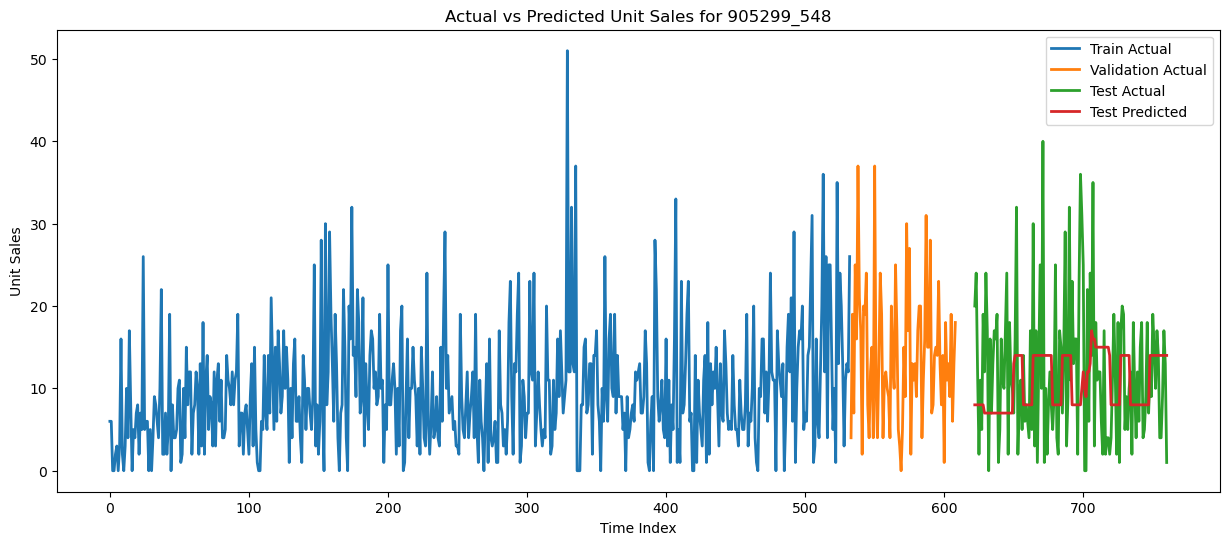

In [8]:
for unique_id in random_unique_ids:
    fig, ax = plt.subplots(figsize=(15, 6))
    
    # Training data
    train_data = training_data[training_data["unique_id"] == unique_id]
    train_actuals = train_data["unit_sales"].values
    train_actuals_range = np.arange(len(train_actuals))
    ax.plot(train_actuals_range, train_actuals, label="Train Actual", linewidth=2)

    # Validation data
    val_data = validation_data[validation_data["unique_id"] == unique_id]
    val_actuals = val_data["unit_sales"].values
    val_actuals_range = np.arange(len(train_actuals), len(train_actuals) + len(val_actuals))
    ax.plot(val_actuals_range, val_actuals, label="Validation Actual", linewidth=2)

    # Test data
    test_data = testing_data[testing_data["unique_id"] == unique_id]
    test_predictions = test_predictions_dict[unique_id]
    actuals = test_data["unit_sales"].values
    test_actuals_range = np.arange(window_size - 1, len(actuals)) + len(train_actuals) + len(val_actuals)
    ax.plot(test_actuals_range, actuals[window_size - 1:], label="Test Actual", linewidth=2)
    ax.plot(test_actuals_range, test_predictions, label="Test Predicted", linestyle="-", linewidth=2)

    ax.set_xlabel("Time Index")
    ax.set_ylabel("Unit Sales")
    ax.set_title(f"Actual vs Predicted Unit Sales for {unique_id}")
    ax.legend()

    plt.show()

# Evaluation Metrics

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

errors = []


# Calculate MASE
def mean_absolute_scaled_error(actuals, predictions, training_data):
    naive_forecast_errors = np.abs(np.diff(training_data["unit_sales"].values))
    naive_forecast_errors = np.mean(naive_forecast_errors)
    prediction_errors = np.abs(actuals - predictions)
    mase = np.mean(prediction_errors) / naive_forecast_errors
    return mase


for unique_id in random_unique_ids:
    # Compute the actuals and predictions
    test_data = testing_data[testing_data["unique_id"] == unique_id]
    actuals = test_data["unit_sales"].values[window_size - 1:]
    predictions = test_predictions_dict[unique_id]

    # Calculate MAE
    mae = mean_absolute_error(actuals, predictions)

    # Calculate MASE
    mase = mean_absolute_scaled_error(actuals, predictions, training_data[training_data["unique_id"] == unique_id])

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(actuals, predictions))

    errors.append({"unique_id": unique_id, "MAE": mae, "MASE": mase, "RMSE": rmse})

errors_df = pd.DataFrame(errors)
errors_df

,unique_id,MAE,MASE,RMSE
0,905299_548,7.410072,1.040147,9.063326


In [10]:
import plotly.graph_objs as go

# Create a box plot for MAE
trace1 = go.Box(
    y=errors_df['MAE'],
    name="MAE",
    boxpoints='outliers',
    jitter=0.3,
    pointpos=0,
    boxmean=True
)

# Create a box plot for RMSE
trace2 = go.Box(
    y=errors_df['RMSE'],
    name="RMSE",
    boxpoints='outliers',
    jitter=0.3,
    pointpos=0,
    boxmean=True
)

# Create a box plot for MASE
trace3 = go.Box(
    y=errors_df['MASE'],
    name="MASE",
    boxpoints='outliers',
    jitter=0.3,
    pointpos=0,
    boxmean=True
)

# Create a layout for the box plots
layout = go.Layout(
    title="Evaluation Metrics",
    yaxis=dict(title="Value"),
    boxmode='group'
)

# Combine the traces and layout into a single figure
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)

# Plot the figure
fig.show()


# Interpretability

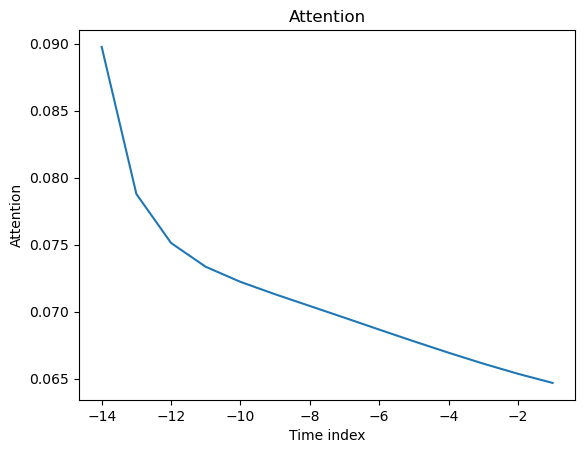

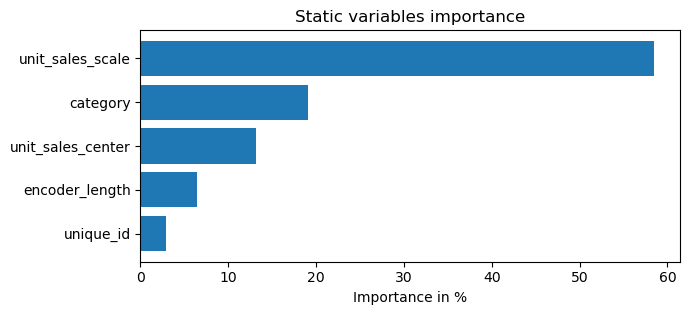

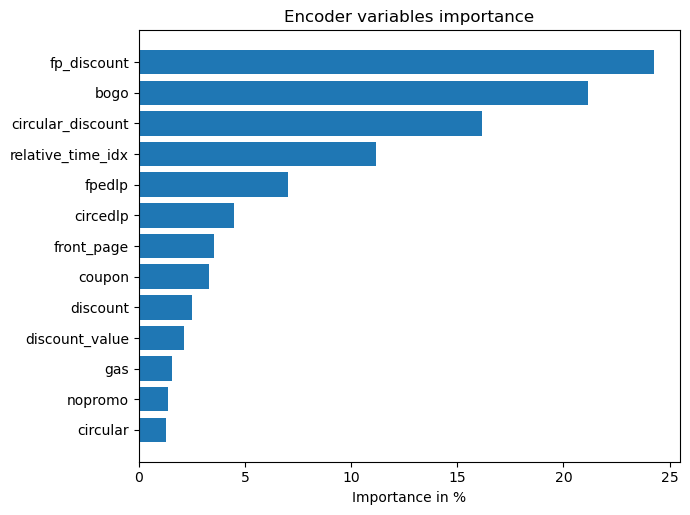

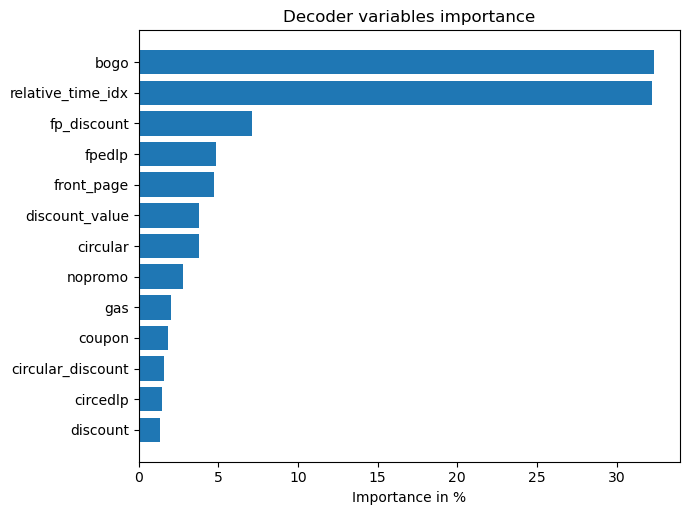

In [11]:
# feature level interpretability
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", 
                     return_x=True)
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation);